In [2]:
import torch
import numpy as np
from torch_geometric.utils import to_edge_index
import matplotlib.pyplot as plt
import networkx as nx
from utils.data import get_data
from networks.VAEs import VAE, Params_VAE
import snf
import pandas as pd
import gower as gw

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
METABRIC_PATH = "./data/MBdata_33CLINwMiss_1KfGE_1KfCNA.csv"


def load_adj(path, normalise=True):
    X = np.genfromtxt(path, delimiter=",")
    np.fill_diagonal(X, 0)
    if normalise:
        X = (X - X.min()) / (X.max() - X.min())
    return X


def get_edge_index(X, threshold=None, N_largest=None):
    if N_largest:
        idx = np.argpartition(X.ravel(), -N_largest * 2)[-N_largest * 2 :]
        threshold = X.ravel()[idx].min()

    if threshold:
        X[X < threshold] = 0

    return to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))


def print_hist(edge_attr):
    plt.hist(edge_attr, log=True, ec="black")
    plt.xlabel("Normalised distance value")
    plt.ylabel("Counts (log)")
    plt.show()


def min_max_normalisation(X):
    return (X - X.min()) / (X.max() - X.min())


def print_graph(edge_index, color_labels):
    nodes = np.unique(edge_index.flatten())
                      
    H = nx.Graph()
    H.add_nodes_from(nodes)
    edges = [(int(e[0]), int(e[1])) for e in zip(edge_index[0], edge_index[1])]
    H.add_edges_from(edges)

    G = nx.Graph()
    G.add_nodes_from(sorted(H.nodes(data=True)))
    G.add_edges_from(H.edges(data=True))

    nx.draw_networkx(
        G,
        with_labels=False,
        node_color=color_labels[np.array(G.nodes())].tolist(),
        node_size=5,
        node_shape=".",
        width=0.25,
    )

    print("Total number of nodes: ", int(G.number_of_nodes()))
    print("Total number of edges: ", int(G.number_of_edges()))
    print("Total number of isolated nodes: ", len(color_labels)-len(nodes))
    print("Max Degree for all nodes: ", np.array(G.degree())[:, 1].max())

    # print("Total number of self-loops: ", int(nx.number_of_selfloops(G)))

    return G

In [3]:
data = pd.read_csv(METABRIC_PATH, index_col=None, header=0, low_memory=False)
data = data.drop(data[data["Pam50Subtype"] == "?"].index)
data

,METABRIC_ID,Cohort,Age_At_Diagnosis,Breast_Tumour_Laterality,Date_Of_Diagnosis,Last_Followup_Status,NPI,ER_Status,Inferred_Menopausal_State,Lymph_Nodes_Positive,...,CNA_FOXM1,CNA_EXOC3,CNA_ARMC7,CNA_KCTD2,CNA_PDCD10,CNA_RHOD,CNA_CFL1,CNA_YBX1,CNA_TRIM24,CNA_RAB11FIP3
0,MB-0002,1,43.19,r,2000/12,a,4.020,pos,pre,0,...,0,0,-1,-1,0,2,2,0,-1,0
1,MB-0005,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,1,...,0,0,0,0,0,1,1,0,2,1
2,MB-0006,1,47.68,r,2001/02,a,4.050,pos,pre,3,...,0,0,0,0,0,0,0,0,1,0
3,MB-0010,1,78.77,l,2001/03,d-d.s.,4.062,pos,post,0,...,0,0,0,0,0,1,1,0,0,2
4,MB-0014,1,56.45,r,2001/04,a,4.020,pos,post,1,...,0,-1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,MB-0291,1,51.19,r,1998/12,d-d.s.,5.052,pos,post,1,...,0,0,0,0,0,0,0,0,-1,0
1976,MB-0444,1,49.87,l,2003/08,d-d.s.,5.066,pos,pre,18,...,1,0,0,0,0,0,0,0,0,0
1977,MB-0482,1,39.53,r,2004/01,d-d.s.,5.032,neg,pre,1,...,0,0,0,0,0,0,0,0,0,0
1978,MB-0519,1,61.99,r,2004/06,a,6.130,pos,post,23,...,0,0,1,1,0,0,0,0,0,1


In [54]:
# clin["Age_At_Diagnosis"]           # Truly numeric
# clin["Breast_Tumour_Laterality"]   # Categorical "L, R" (3 unique)
# clin["NPI"]                        # Truly numeric
# clin["Inferred_Menopausal_State"]  # Categorical "Pre, Post" (3 unique)
# clin["Lymph_Nodes_Positive"]       # Ordinal ints 0-24
# clin["Grade"]                      # Ordinal string (come on) 1-3 + "?"
# clin["Size"]                       # Truly Numeric
# clin["Histological_Type"]          # Categorical strings (9 unique)
# clin["Cellularity"]                # Categorical strings (4 unique)
# clin["Breast_Surgery"]             # Categorical strings (3 Unique)
# clin["CT"]                         # Categorical strings (9 unique)
# clin["HT"]                         # Categorical strings (9 Unique)
# clin["RT"]                         # Categorical strings (9 Unique)

clin = data[["Age_At_Diagnosis","Breast_Tumour_Laterality","NPI","Inferred_Menopausal_State","Lymph_Nodes_Positive","Grade","Size","Histological_Type","Cellularity","Breast_Surgery","CT","HT","RT"]]   

In [31]:
labels = np.array(data["Pam50Subtype"]).tolist()

color_codes = {
    "LumA":"tab:red",
    "LumB":"tab:pink",
    "Normal":"tab:green",
    "Basal":"tab:blue",
    "Her2":"tab:brown"}

color_labels = np.array([color_codes[l] for l in labels])
len(color_labels)

1974

In [61]:
rna = data[[col for col in data if col.startswith("GE")]]
cna = data[[col for col in data if col.startswith("CNA")]]

rna

,GE_GRB7,GE_LSM1,GE_CLNS1A,GE_STARD3,GE_PPFIA1,GE_ERBB2,GE_INTS4,GE_ORMDL3,GE_PSMB3,GE_MTERFD1,...,GE_TMEM99,GE_ZNHIT3,GE_FOXM1,GE_EXOC3,GE_ARMC7,GE_KCTD2,GE_PDCD10,GE_RHOD,GE_YBX1,GE_TRIM24
0,6.487146,11.031136,10.079148,6.031175,9.487621,9.729606,8.253549,6.511952,10.423016,8.419615,...,8.822871,7.922863,5.677913,7.426484,6.194931,5.962671,9.093493,9.407661,9.526590,7.306828
1,6.479166,10.873850,10.322188,5.846570,9.053110,9.725825,7.873861,6.627166,11.203083,8.515613,...,9.504050,8.724618,6.054136,7.013241,6.641685,5.784853,9.330020,8.623256,9.545137,8.624840
2,7.874277,11.381911,9.550389,6.212065,8.822194,10.334979,7.312676,7.164516,11.910947,9.153356,...,9.314667,9.420298,5.774602,7.374062,6.782999,6.655940,9.856422,9.663621,9.942894,8.278145
3,6.351296,10.433402,9.736490,5.885852,8.981401,9.739996,7.728910,6.663150,11.050693,8.540313,...,8.644579,7.378990,6.735173,7.453835,7.132947,6.392015,8.899136,8.579820,9.795769,7.705012
4,6.354046,11.074266,9.968607,5.876592,8.861144,9.276507,7.643929,6.793206,11.425601,8.650009,...,9.122584,9.538950,5.665971,6.726317,6.362663,6.229215,10.877762,8.127024,9.346105,7.549302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,10.140878,9.922808,9.793351,8.499444,9.248419,13.544826,8.016338,9.364325,12.571661,9.026180,...,8.771963,7.023838,6.227668,7.625258,6.470248,6.529098,8.376922,8.350534,10.036168,7.050074
1976,6.537403,10.851758,9.736496,6.228521,9.112063,9.638722,8.039574,6.642969,11.025569,8.669941,...,8.860046,6.837227,6.635761,7.967124,7.289758,6.800664,8.402668,8.616863,8.921698,7.312001
1977,7.528923,10.198299,9.256651,8.299259,8.913670,14.091119,7.734503,7.328970,10.808555,8.966377,...,9.176036,7.141902,6.311511,7.742799,6.250673,6.761721,8.654583,8.631720,10.292226,7.037643
1978,6.513042,10.347624,9.474540,6.252596,8.635856,9.140828,7.873670,7.779414,11.007943,9.177260,...,8.980925,7.589224,6.119348,8.132514,6.673989,6.658595,8.696216,7.811217,9.940413,6.929874


In [25]:
snf_rna = snf.make_affinity(rna, metric="cosine")
np.fill_diagonal(snf_rna,0)
norm_snf_rna = min_max_normalisation(snf_rna)
norm_snf_rna

array([[0.        , 0.01526992, 0.00785584, ..., 0.02923584, 0.01074515,
        0.02148386],
       [0.01526992, 0.        , 0.04383652, ..., 0.00309939, 0.00236893,
        0.0150794 ],
       [0.00785584, 0.04383652, 0.        , ..., 0.00450353, 0.00805879,
        0.01744463],
       ...,
       [0.02923584, 0.00309939, 0.00450353, ..., 0.        , 0.01347264,
        0.0292981 ],
       [0.01074515, 0.00236893, 0.00805879, ..., 0.01347264, 0.        ,
        0.01733022],
       [0.02148386, 0.0150794 , 0.01744463, ..., 0.0292981 , 0.01733022,
        0.        ]])

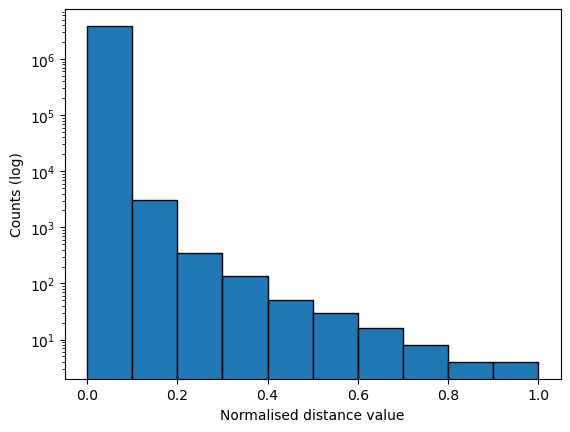

In [26]:
e_i_rna, e_a_rna = get_edge_index(norm_snf_rna)
print_hist(e_a_rna)

In [39]:
temp = norm_snf_rna.copy()
e_i_rna, e_a_rna = get_edge_index(temp, threshold=0.1)

Total number of nodes:  897
Total number of edges:  1848
Total number of isolated nodes:  1077
Max Degree for all nodes:  31


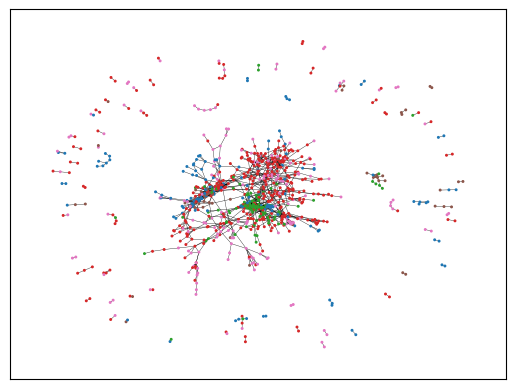

In [40]:
print_graph(e_i_rna, color_labels)

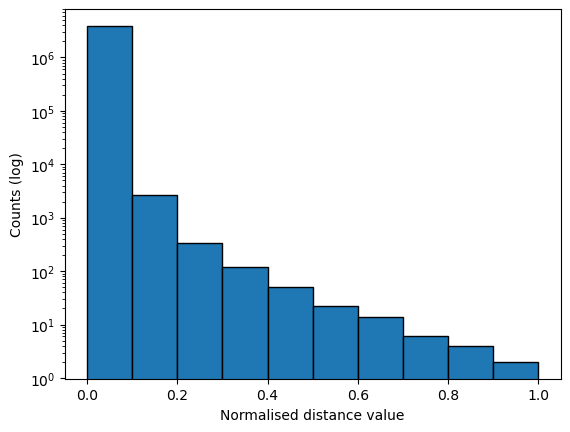

In [42]:
snf_rna_corr = snf.make_affinity(rna, metric="correlation")
np.fill_diagonal(snf_rna_corr,0)
norm_snf_rna_corr = min_max_normalisation(snf_rna_corr)
e_i_rna, e_a_rna = get_edge_index(norm_snf_rna_corr)
print_hist(e_a_rna)

Total number of nodes:  1547
Total number of edges:  4776
Total number of isolated nodes:  427
Max Degree for all nodes:  38


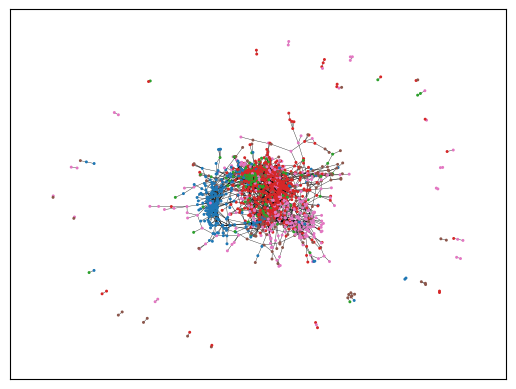

In [51]:
temp = norm_snf_rna.copy()
e_i_rna, e_a_rna = get_edge_index(temp, threshold=0.075)
print_graph(e_i_rna, color_labels)

In [57]:
snf_cli = gw.gower_matrix(clin) 
np.fill_diagonal(snf_cli,0)

snf_cli

array([[0.        , 0.3923441 , 0.47174197, ..., 0.3277114 , 0.6275071 ,
        0.7509875 ],
       [0.3923441 , 0.        , 0.31262916, ..., 0.4855804 , 0.6197784 ,
        0.5124896 ],
       [0.47174197, 0.31262916, 0.        , ..., 0.33363503, 0.5403805 ,
        0.58693784],
       ...,
       [0.3277114 , 0.4855804 , 0.33363503, ..., 0.        , 0.5381372 ,
        0.66161764],
       [0.6275071 , 0.6197784 , 0.5403805 , ..., 0.5381372 , 0.        ,
        0.56955135],
       [0.7509875 , 0.5124896 , 0.58693784, ..., 0.66161764, 0.56955135,
        0.        ]], dtype=float32)

In [58]:
norm_snf_cli = min_max_normalisation(snf_cli)
norm_snf_cli

array([[0.        , 0.42941537, 0.5163153 , ..., 0.35867575, 0.6867981 ,
        0.8219458 ],
       [0.42941537, 0.        , 0.34216845, ..., 0.5314613 , 0.6783392 ,
        0.560913  ],
       [0.5163153 , 0.34216845, 0.        , ..., 0.3651591 , 0.5914392 ,
        0.6423956 ],
       ...,
       [0.35867575, 0.5314613 , 0.3651591 , ..., 0.        , 0.58898395,
        0.72413164],
       [0.6867981 , 0.6783392 , 0.5914392 , ..., 0.58898395, 0.        ,
        0.62336636],
       [0.8219458 , 0.560913  , 0.6423956 , ..., 0.72413164, 0.62336636,
        0.        ]], dtype=float32)

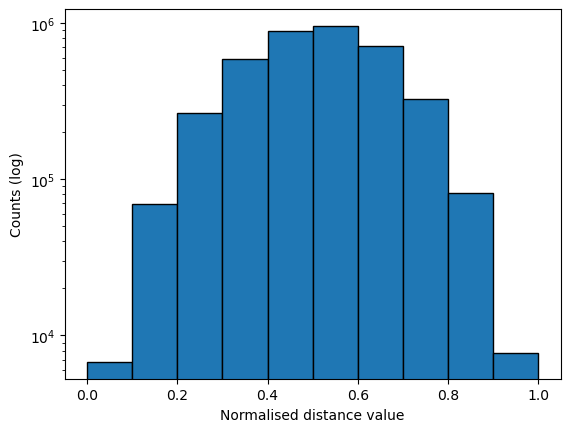

In [59]:
e_i_cli, e_a_cli = get_edge_index(norm_snf_cli)
print_hist(e_a_cli)

In [4]:
# clin = data[["Age_At_Diagnosis","Breast_Tumour_Laterality","NPI","Inferred_Menopausal_State","Lymph_Nodes_Positive","Grade","Size","Histological_Type","Cellularity","Breast_Surgery","CT","HT","RT"]]   

# SUPREME - We collected age, menopause status, race, tumor stage, tumor status, estrogen receptor status, progesterone receptor status, and HER2 status

columns = ['Age_At_Diagnosis',
 'NPI',
 'Lymph_Nodes_Positive',
 'Size',
 'ER_Status',
 'Inferred_Menopausal_State',
 
 'CT',
 'HT',
 'RT',
 'Grade',
 
 'Histological_Type',
 'Stage',
 'Cellularity',
#  'DeathBreast',
#  'TLR',
#  'LR',
#  'TDR',
#  'DR',
 'HER2_SNP6',
 'ER_Expr',
 'Her2_Expr',
 'PR_Expr',
]

columns = ['Age_At_Diagnosis',
 'NPI',
 'Lymph_Nodes_Positive',
 'Size',
 'ER_Status',
 'Inferred_Menopausal_State',
 'Breast_Tumour_Laterality',
 'CT',
 'HT',
 'RT',
 'Grade',
 
 'Histological_Type',
 'Stage',
 'Cellularity',
#  'DeathBreast',
#  'TLR',
#  'LR',
#  'TDR',
#  'DR',
 'HER2_SNP6',
 'ER_Expr',
 'Her2_Expr',
 'PR_Expr',
]

clin = data[columns]
clin

,Age_At_Diagnosis,NPI,Lymph_Nodes_Positive,Size,ER_Status,Inferred_Menopausal_State,Breast_Tumour_Laterality,CT,HT,RT,Grade,Histological_Type,Stage,Cellularity,HER2_SNP6,ER_Expr,Her2_Expr,PR_Expr
0,43.19,4.020,0,10,pos,pre,r,NO/NA,TAM,CW,3,IDC,1,high,NEUT,+,-,+
1,48.87,4.030,1,15,pos,pre,r,OTHER,TAM,NO/NA,2,IDC,2,high,NEUT,+,-,+
2,47.68,4.050,3,25,pos,pre,r,OTHER,AI,CW,2,IDC,2,moderate,NEUT,+,-,+
3,78.77,4.062,0,31,pos,post,l,NO/NA,TAM,CW,3,IDC,4,moderate,NEUT,+,-,+
4,56.45,4.020,1,10,pos,post,r,AC,TAM,CW,2,IDC,2,moderate,LOSS,+,-,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,51.19,5.052,1,26,pos,post,r,OTHER,TAM,NO/NA,3,IDC,2,moderate,GAIN,+,+,+
1976,49.87,5.066,18,33,pos,pre,l,NO/NA,AI,CW-NODAL,2,ILC,4,moderate,NEUT,+,-,+
1977,39.53,5.032,1,16,neg,pre,r,OTHER,NO/NA,CW,3,IDC,2,moderate,GAIN,-,+,-
1978,61.99,6.130,23,65,pos,post,r,PACL,TAM/AI,CW-NODAL,3,IDC,3,moderate,LOSS,+,-,-


In [47]:
complete_data = data[columns]
aad = pd.get_dummies(
        pd.cut(
            complete_data["Age_At_Diagnosis"],
            10,
            labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        ),
        prefix="aad",
        dummy_na=True,
    )
npi = pd.get_dummies(
        pd.cut(complete_data["NPI"], 6, labels=[1, 2, 3, 4, 5, 6]),
        prefix="npi",
        dummy_na=True,
    )
size = pd.get_dummies(complete_data["Size"], prefix="size", dummy_na=True)

# Categorical and ordinals to one-hot dummies
btl = pd.get_dummies(
    complete_data["Breast_Tumour_Laterality"], prefix="btl", dummy_na=True
)
ims = pd.get_dummies(
    complete_data["Inferred_Menopausal_State"], prefix="ims", dummy_na=True
)
lnp = pd.get_dummies(
    complete_data["Lymph_Nodes_Positive"], prefix="lnp", dummy_na=True
)
grade = pd.get_dummies(complete_data["Grade"], prefix="grade", dummy_na=True)
hist = pd.get_dummies(
    complete_data["Histological_Type"], prefix="hist", dummy_na=True
)
cellularity = pd.get_dummies(
    complete_data["Cellularity"], prefix="cellularity", dummy_na=True
)
ct = pd.get_dummies(complete_data["CT"], prefix="ct", dummy_na=True)
ht = pd.get_dummies(complete_data["HT"], prefix="ht", dummy_na=True)
rt = pd.get_dummies(complete_data["RT"], prefix="rt", dummy_na=True)

clin_transformed = pd.concat(
        [
            # aad,
            npi,
            size,
            btl,
            ims,
            lnp,
            grade,
            hist,
            cellularity,
            ct,
            ht,
            rt,
        ],
        axis=1,
    )

clin_transformed = clin_transformed.astype(np.float32).values

In [56]:
snf_cli = snf.make_affinity(clin_transformed, metric="hamming")
np.fill_diagonal(snf_cli,0)
snf_cli = min_max_normalisation(snf_cli)
snf_cli

array([[0.        , 0.00177744, 0.0014812 , ..., 0.00052081, 0.00027361,
        0.00014032],
       [0.00177744, 0.        , 0.00664417, ..., 0.0014812 , 0.00035849,
        0.00105618],
       [0.0014812 , 0.00664417, 0.        , ..., 0.00585826, 0.00116727,
        0.00094416],
       ...,
       [0.00052081, 0.0014812 , 0.00585826, ..., 0.        , 0.00112943,
        0.00090191],
       [0.00027361, 0.00035849, 0.00116727, ..., 0.00112943, 0.        ,
        0.00086102],
       [0.00014032, 0.00105618, 0.00094416, ..., 0.00090191, 0.00086102,
        0.        ]])

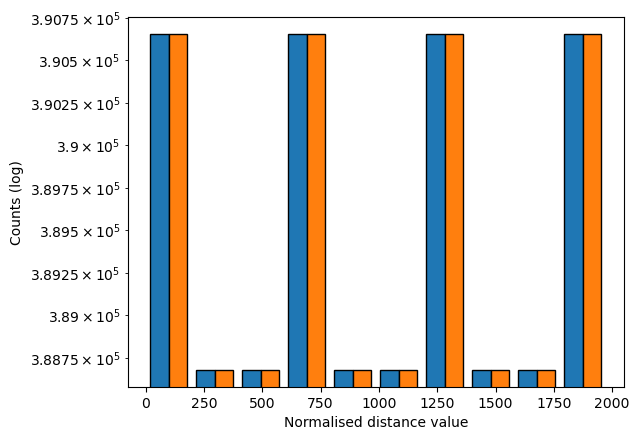

In [57]:
e_i_cli, e_a_cli = get_edge_index(snf_cli)
print_hist(e_i_cli)

Total number of nodes:  1906
Total number of edges:  10315
Total number of isolated nodes:  68
Max Degree for all nodes:  32


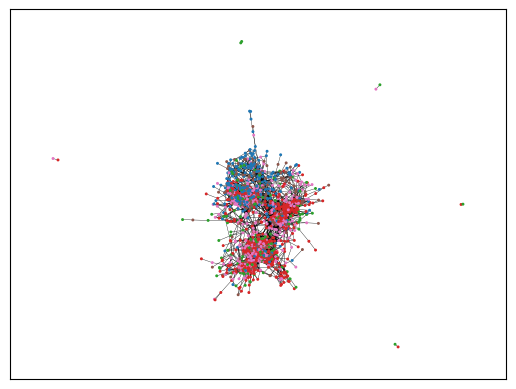

In [59]:
temp = snf_cli.copy()
e_i_cli, e_a_cli = get_edge_index(temp, N_largest=10000)
print_graph(e_i_cli, color_labels)

In [62]:
snf_cli = snf.make_affinity(clin_transformed, metric="hamming")
snf_rna_corr = snf.make_affinity(rna, metric="correlation")

snf_all = snf.compute.snf([snf_cli,snf_rna_corr])
# snf_all = min_max_normalisation(snf_all)
# np.fill_diagonal(snf_all, 0)

In [70]:
np.fill_diagonal(snf_all, 0)
np.savetxt("./data/SNF/SNF_CLI_RNA.csv", snf_all, delimiter=",")


Total number of nodes:  1912
Total number of edges:  4500
Total number of isolated nodes:  62
Max Degree for all nodes:  25


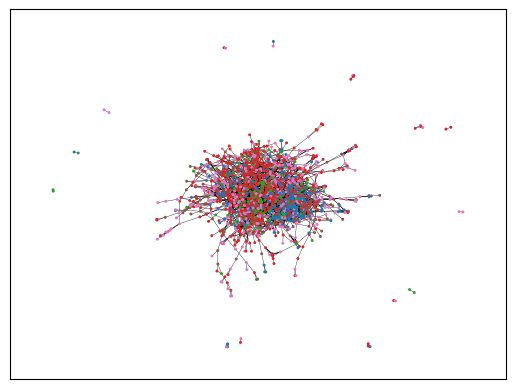

In [68]:
temp = snf_all.copy()
np.fill_diagonal(temp, 0)
e_i_all, e_a_all = get_edge_index(temp, N_largest=4500)
print_graph(e_i_all, color_labels)

In [20]:
omics_names = ["CLI", "RNA", "CNA"]
latents = {}
latent_sim = {}
for name in omics_names:
    input_dim = 1000
    if name == "CLI":
        input_dim = 350

    dense_dim = 256
    latent_dim = 128

    vae_path = f"../IntegrativeVAE/results/VAE_{name}/0122141739/fold_1/VAE.pth"

    vae_params = Params_VAE(input_dim, dense_dim, latent_dim)
    vae = VAE(vae_params)
    vae.load_state_dict(torch.load(vae_path))
    vae.eval()
    vae.to(DEVICE)

    _, _, _, _, z = vae.forward(torch.tensor(metabric[name], dtype=torch.float32))
    latents[name] = z.detach().cpu().numpy()

    temp = np.corrcoef(latents[name])
    np.fill_diagonal(temp, 0)
    latent_sim[name] = temp

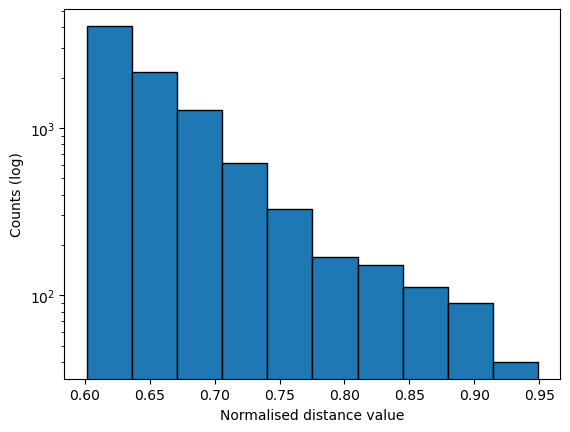

Total number of nodes:  1308
Total number of edges:  4500
Max Degree for all nodes:  45
Total number of self-loops:  0


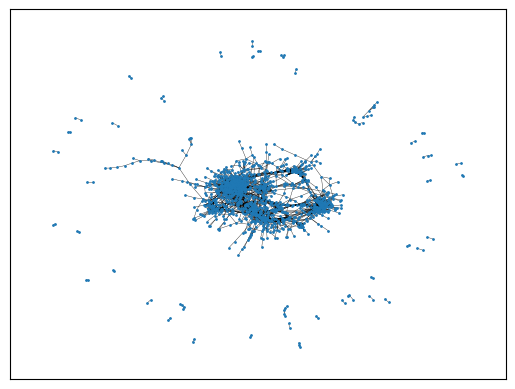

In [22]:
e_i_rna, e_a_rna = get_edge_index(latent_sim["RNA"], N_largest=4500)
print_hist(e_a_rna)
print_graph(e_i_rna)

In [24]:
e_i_rna

tensor([[   1,    1,    1,  ..., 1971, 1972, 1972],
        [   2,    4,    6,  ...,  233,   97, 1959]])

In [78]:
edge_indices = []
edge_attributes = []
for name in ["CLI", "RNA"]:
    e_i, e_a = get_edge_index(latent_sim[name], N_largest=4500)
    edge_indices.append(e_i)
    edge_attributes.append(e_a)

edge_index_comb = [[],[]]
edge_attr_comb = []
for i in range(len(edge_indices[0][0])):
    if(edge_indices[0][0][i]==edge_indices[1][0][i]) & (edge_indices[0][1][i]==edge_indices[1][1][i]):
        print("a")
    else:
        for n in range(2):
            edge_index_comb[0].append(edge_indices[n][0][i])
            edge_index_comb[1].append(edge_indices[n][1][i])
            edge_attr_comb.append(n)

edge_index_comb = torch.tensor(edge_index_comb)
edge_attr_comb = torch.tensor(edge_attr_comb)

In [79]:
edge_index_comb

tensor([[   0,    1,    0,  ..., 1972, 1971, 1972],
        [ 549,    2,  586,  ...,   97, 1541, 1959]])

In [80]:
edge_attr_comb

tensor([0, 1, 0,  ..., 1, 0, 1])

In [61]:
len(edge_indices[0][1])

9000

In [25]:
e_i_cli, e_a_cli = get_edge_index(latent_sim["CLI"], N_largest=4500)
e_i_cli

tensor([[   0,    0,    0,  ..., 1971, 1971, 1971],
        [ 549,  586,  706,  ...,  482, 1140, 1541]])

In [40]:
e = (torch.tensor(1),torch.tensor(1))
n = (torch.tensor(1),torch.tensor(1))
e == n

True

In [55]:
list_cli = list(zip(e_i_cli[0],e_i_cli[1]))
list_rna = list(zip(e_i_rna[0],e_i_rna[1]))

# t_c = [[1,2,3],[4,4,4]]
# t_r = [[1,2,3],[4,1,1]]

# list_cli = list(zip(t_c[0],t_c[1]))
# list_rna = list(zip(t_r[0],t_r[1]))

e_a_comb = []
e_i_comb_1 = []
e_i_comb_2 = []
for i in range(len(list_cli)):
    if list_cli[i]==list_rna[i]:
        print("a")
        # e_a_comb
    else:
        e_i_comb_1.append(int(list_cli[i][0]))
        e_i_comb_2.append(int(list_cli[i][1]))

        e_a_comb.append(0)

        e_i_comb_1.append(int(list_rna[i][0]))
        e_i_comb_2.append(int(list_rna[i][1]))

        e_a_comb.append(1)



In [53]:
len(torch.tensor([e_i_comb_1,e_i_comb_2]))

18000

In [56]:
torch.tensor(e_a_comb)

tensor([0, 1, 0,  ..., 1, 0, 1])

In [16]:
c = np.corrcoef(latents["RNA"])
np.fill_diagonal(c,0)
c

array([[ 0.        ,  0.30413118,  0.11802054, ...,  0.33741092,
        -0.06136601,  0.08827021],
       [ 0.30413118,  0.        ,  0.5948033 , ...,  0.01132687,
        -0.05760606, -0.00222942],
       [ 0.11802054,  0.5948033 ,  0.        , ...,  0.03530365,
         0.10745423,  0.17394413],
       ...,
       [ 0.33741092,  0.01132687,  0.03530365, ...,  0.        ,
        -0.00063943,  0.21271735],
       [-0.06136601, -0.05760606,  0.10745423, ..., -0.00063943,
         0.        ,  0.06369366],
       [ 0.08827021, -0.00222942,  0.17394413, ...,  0.21271735,
         0.06369366,  0.        ]])

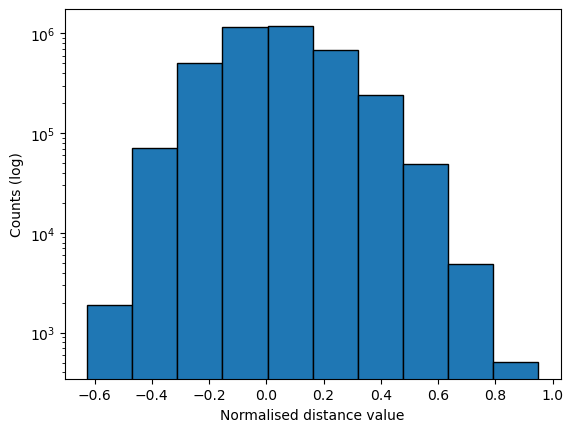

In [13]:
edge_index, edge_attr = get_edge_index(c)
print_hist(edge_attr)

Total number of nodes:  1820
Total number of edges:  14000
Max Degree for all nodes:  100
Total number of self-loops:  0


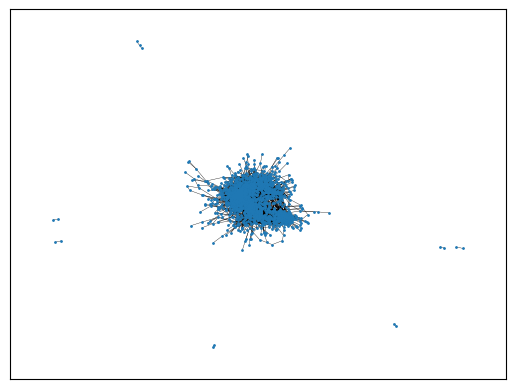

In [17]:
edge_index, edge_attr = get_edge_index(c, N_largest=14000)
print_graph(edge_index)

In [ ]:
snf_cli = gw.gower_matrix(metabric["CLI"]) 
snf_rna = np.corrcoef(metabric["RNA"])

In [20]:
len(latent_sim)

3

In [23]:
snf_all = snf.compute.snf(latent_sim, K=20)
np.fill_diagonal(snf_all,0)

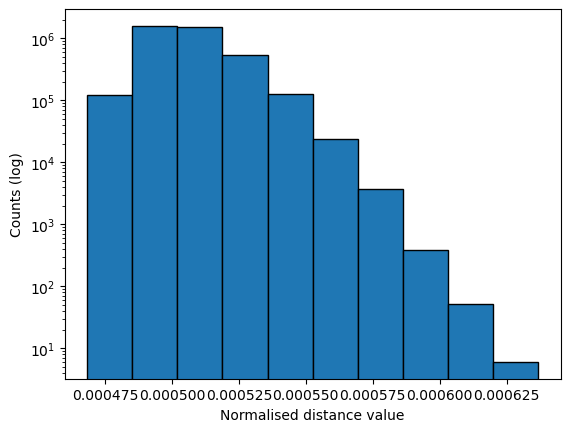

In [24]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c)
print_hist(edge_attr)

Total number of nodes:  1974
Total number of edges:  30000
Max Degree for all nodes:  59
Total number of self-loops:  0


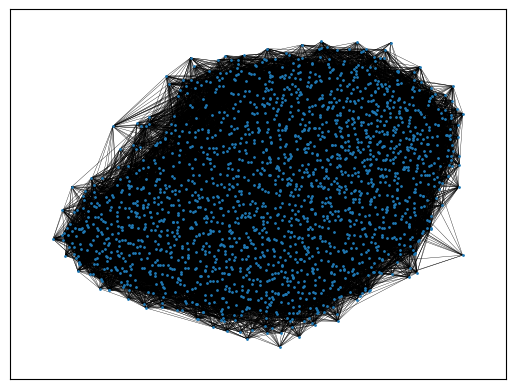

In [29]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c, N_largest=30000)
print_graph(edge_index)

# CLI

In [7]:
snf_cli = snf.make_affinity(latents["CLI"], metric="euclidean", K=5)
np.fill_diagonal(snf_cli,0)
snf_cli = min_max_normalisation(snf_cli)

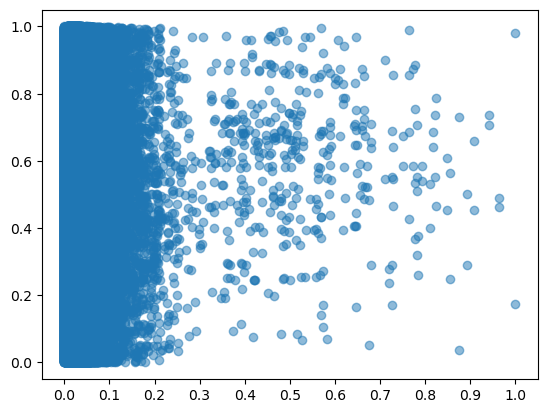

In [8]:
x = [k[0] for k in snf_cli.reshape(-1, 1).tolist()]
y = np.linspace(0, 1, len(x))

plt.scatter(x, y, alpha=0.5)
plt.xticks([i / 10 for i in range(11)])
plt.show()

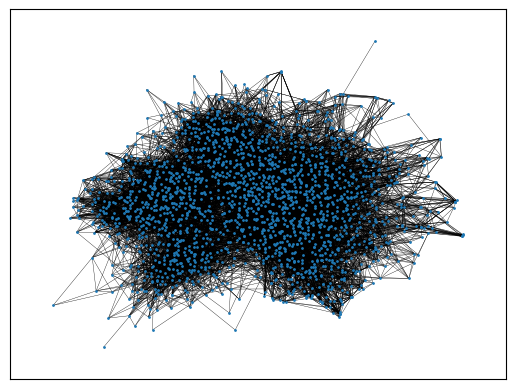

In [37]:
X = snf_cli.copy()
X[X < 0.05] = 0
edge_index, _ =  to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))
G = print_graph(edge_index)

# CLI+RNA+CNA

In [26]:
K = 20
adj_all = snf.make_affinity([latents["CLI"], latents["CNA"], latents["RNA"]], metric="correlation", K=K)
# adj_all = [min_max_normalisation(adj) for adj in adj_all]
snf_all = snf.compute.snf(adj_all, K=K)
# snf_all = min_max_normalisation(snf_all)
np.fill_diagonal(snf_all, 0)

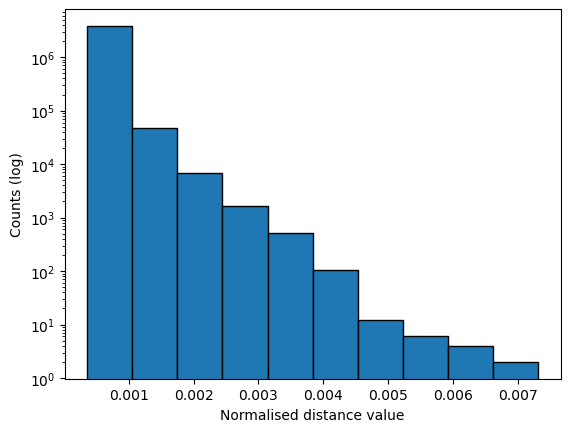

In [30]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c)
print_hist(edge_attr)

Total number of nodes:  1960
Total number of edges:  7000
Max Degree for all nodes:  30
Total number of self-loops:  0


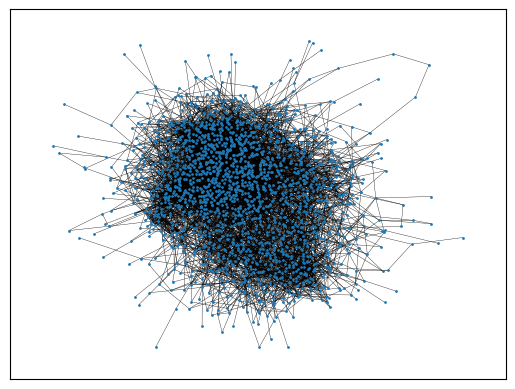

In [32]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c, N_largest=7000)
print_graph(edge_index)